In [226]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.field_names import FieldName
from gluonts.mx.trainer.callback import TrainingHistory
from sklearn.preprocessing import LabelEncoder

from gluonts.time_feature import (
    day_of_week,
    day_of_month,
    day_of_year,
    week_of_year,
    month_of_year,
)

from gluonts.time_feature.holiday import (
   squared_exponential_kernel,
   SpecialDateFeatureSet,
   CHRISTMAS_DAY,
   CHRISTMAS_EVE
)

import optuna
import torch
from gluonts.dataset.split import split
from gluonts.evaluation import Evaluator
from gluonts.torch.model.deepar import DeepAREstimator

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/usr/local/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <94665823-CE13-3FCB-92F4-D5CD3E36B593> /usr/local/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B5DCF36B-AC07-3EF2-A997-D38A25D2CCE2> /usr/local/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from sour

#### Read dataset

In [2]:
EVdf0 = pd.read_csv("EVChargingData2010_2020.csv", low_memory=False)

#### Data cleaning

In [3]:
pd.set_option('display.max_column', None)
EVdf0.head()

,Station Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Type,Port Number,Plug Type,Postal Code,Latitude,Longitude,Ended By,Plug In Event Id,Driver Postal Code,User ID
0,HAMILTON 1,7/29/11 20:17,PDT,7/29/11 23:20,PDT,7/29/11 23:20,3:03:32,1:54:03,6.249457,2.625,0.784,Level 2,2,J1772,94301,37.444572,-122.160309,Plug Out at Vehicle,3,95124.0,3284
1,HAMILTON 1,7/30/11 0:00,PDT,7/30/11 0:02,PDT,7/30/11 0:02,0:02:06,0:01:54,0.106588,0.045,0.013,Level 2,2,J1772,94301,37.444572,-122.160309,Customer,4,94301.0,4169
2,HAMILTON 1,7/30/11 8:16,PDT,7/30/11 12:34,PDT,7/30/11 12:34,4:17:32,4:17:28,14.951777,6.280,1.876,Level 2,2,J1772,94301,37.444572,-122.160309,Plug Out at Vehicle,5,94301.0,4169
3,HAMILTON 1,7/30/11 14:51,PDT,7/30/11 16:55,PDT,7/30/11 16:55,2:03:24,2:02:58,7.159643,3.007,0.899,Level 2,2,J1772,94301,37.444572,-122.160309,Customer,6,94302.0,2545
4,HAMILTON 1,7/30/11 18:51,PDT,7/30/11 20:03,PDT,7/30/11 20:03,1:11:24,0:43:54,1.957765,0.822,0.246,Level 2,2,J1772,94301,37.444572,-122.160309,Plug Out at Vehicle,7,94043.0,3765


In [4]:
EVdf0.dropna(inplace = True)

In [5]:
EVdf0.drop_duplicates(inplace = True)

#### Aggregation based on given time window

In [6]:
def convert_duration_to_time_window(duration_str, time_window='1H'):
    """
        Convert charging duration from hh:mm:ss format to the specified time window unit.
        
        Parameters:
            duration_str (str): The charging duration in hh:mm:ss format.
            time_window (str): The time window for conversion. Can be '1H', '1D', '1W', or '1M'.
            
        Returns:
            float: The duration converted to the specified time window unit.
        """
    # Convert hh:mm:ss to total hours
    total_hours = pd.Timedelta(duration_str).total_seconds() / 3600

    # Convert based on the specified time window
    if time_window == '1H':
        return total_hours
    elif time_window == '1D':
        return total_hours / 24
    elif time_window == '1W':
        return total_hours / (24 * 7)
    elif time_window == '1M':
        return total_hours / (24 * 30)
    else:
        raise ValueError("Unsupported time window. Choose from '1H', '1D', '1W', '1M'.")

In [7]:
def aggregate_ev_charging(data, time_window='1H'):
    """
    Aggregate energy consumption, total charging duration, and count EV charging events
    within specified time windows.
    
    Parameters:
        dataframe (pd.DataFrame): The EV charging data.
        time_window (str): The time window for aggregation. Can be '1H', '1D', '1W', or '1M'.
        
    Returns:
        pd.DataFrame: Aggregated data with total energy, total charging duration, and count of events.
    """
    dataframe = data.copy()

    dataframe['Start Date'] = pd.to_datetime(dataframe['Start Date'], errors='coerce')

    dataframe = dataframe.dropna(subset=['Start Date'])

    # Ensure the Transaction Date is in datetime format
    dataframe['Start Date'] = pd.to_datetime(dataframe['Start Date'], format="%m/%d/%y %H:%M")

    dataframe.set_index('Start Date', inplace=True)
    
    # Convert Charging Time to hours
    dataframe[f'Charging Time ({time_window})'] = dataframe['Charging Time (hh:mm:ss)'].apply(convert_duration_to_time_window)
    
    # Resample and aggregate data
    aggregated_data = dataframe.groupby('Station Name').resample(time_window).agg({
        'Energy (kWh)': 'sum',
        f'Charging Time ({time_window})': 'sum',
        'User ID': 'count'  # Count of events
    })
    
    # Rename the columns
    aggregated_data.rename(columns={
        'Energy (kWh)': 'Total Energy (kWh)',
        f'Charging Time ({time_window})': f'Total Charging Duration ({time_window})',
        'User ID': 'Event Count'
    }, inplace=True)
    
    return aggregated_data.reset_index()

In [8]:
# Example usage
## frequency: 1H, 1D, 1W, 1M
freq = '1D'
EVdata = aggregate_ev_charging(EVdf0, freq)

In [9]:
# Set 'Start Date' as the index
EVdata.set_index('Start Date', inplace=True)

In [10]:
EVdata.head()

,Station Name,Total Energy (kWh),Total Charging Duration (1D),Event Count
Start Date,,,,
2011-10-13,BRYANT 1,8.262052,2.226944,2
2011-10-14,BRYANT 1,6.259466,1.698333,1
2011-10-15,BRYANT 1,4.622894,1.595278,1
2011-10-16,BRYANT 1,0.000000,0.000000,0
2011-10-17,BRYANT 1,4.023361,1.510556,1


##### Multiple series

In [11]:
def multiple_time_series(data, target, fields):
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    testData = data.loc[:, fields]
    testData = testData.rename(columns = {"Total Energy (kWh)": "target"})
    testData['item_id'] = label_encoder.fit_transform(testData['Station Name'])
    station_name_map = testData[['Station Name', 'item_id']]
    testData.drop(columns = ['Station Name'], inplace = True)
    return testData, station_name_map

In [12]:
target = "Energy (kWh)"
# fields = ["counts", "Energy (kWh)"]
fields = ["Station Name", "Event Count", "Total Energy (kWh)", f"Total Charging Duration ({freq})"]

# testData = one_or_multiple_time_series(EVdata, station_name_list, target, item_id, fields)
testData, station_name_map = multiple_time_series(EVdata, target, fields)
testData.head()


,Event Count,target,Total Charging Duration (1D),item_id
Start Date,,,,
2011-10-13,2,8.262052,2.226944,0
2011-10-14,1,6.259466,1.698333,0
2011-10-15,1,4.622894,1.595278,0
2011-10-16,0,0.000000,0.000000,0
2011-10-17,1,4.023361,1.510556,0


In [13]:
station_name_map = station_name_map.reset_index().drop(columns = ["Start Date"]).drop_duplicates().reset_index().drop(columns = ["index"])

#### Handle missing data

In [14]:
ds = PandasDataset.from_long_dataframe(testData, target="target", item_id="item_id", freq = freq)

In [15]:
max_end = max(testData.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in testData.groupby("item_id"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1D")
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)
    dfs_dict[item_id][np.isnan(dfs_dict[item_id])] = 0
# print(dfs_dict)

In [16]:
ds = PandasDataset(dfs_dict, target="target")
counts = np.array([dfs_dict[item].loc[:, "Event Count"].to_numpy() for item in dfs_dict])
charge_duration = np.array([dfs_dict[item].loc[:, "Total Charging Duration (1D)"].to_numpy() for item in dfs_dict])

/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_42428/1775071469.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  counts = np.array([dfs_dict[item].loc[:, "Event Count"].to_numpy() for item in dfs_dict])
/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_42428/1775071469.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  charge_duration = np.array([dfs_dict[item].loc[:, "Total Charging Duration (1D)"].to_numpy() for item in dfs_dict])


#### Add multiple features

##### Number of counts

In [17]:
train_val_test_split = [0.7, 0.2, 0.1]
train_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[0])
validation_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[1])
prediction_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[2])
train_start = pd.Period(EVdata.index.min(), freq = freq)

##### Temporal variables

In [18]:
holidat_set = SpecialDateFeatureSet([CHRISTMAS_EVE, CHRISTMAS_DAY])

In [19]:
start_date = EVdata.index.min()
end_date = EVdata.index.max()
start_date, end_date

(Timestamp('2011-07-29 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [20]:
date_indices = pd.date_range(
    start = start_date,
    end = end_date,
    freq = freq
)

In [21]:
day_of_week_variable = np.array([day_of_week(date_indices) for item in ds])
day_of_month_variable = np.array([day_of_month(date_indices) for item in ds])
day_year_variable = np.array([day_of_year(date_indices) for item in ds])
week_of_year_variable = np.array([week_of_year(date_indices) for item in ds])
month_of_year_variable = np.array([month_of_year(date_indices) for item in ds])

In [22]:
len(day_of_week_variable[10])

3444

In [23]:
len(day_of_week_variable[0][:train_length])

2357

#### Use train and split

##### Pad multiple time seires

In [24]:
max_length = max(len(item['target']) for item in ds)
padded_targets = [np.pad(arr['target'], (max_length - len(arr['target']), 0), mode='constant') for arr in ds]
target = np.vstack(padded_targets)

In [25]:
len(target[0])

3444

In [26]:
max_length_counts = max(len(item) for item in counts)
padded_counts = [np.pad(arr, (max_length_counts - len(arr), 0), mode='constant') for arr in counts]
padded_counts_stack = np.vstack(padded_counts)

In [27]:
max_length_duration = max(len(item) for item in charge_duration)
padded_duration = [np.pad(arr, (max_length_duration - len(arr), 0), mode='constant') for arr in charge_duration]
padded_duration_stack = np.vstack(padded_duration)

In [28]:
target

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ..., 32.285, 45.451, 24.72 ],
       [ 0.   ,  0.   ,  0.   , ..., 22.485,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ..., 37.291, 47.706,  7.075]])

In [29]:
target.ndim

2

In [30]:
len(target[:, :train_length])

46

In [31]:
start_date_period = pd.Period(EVdata.index.min(), freq=freq)
start_stack = [start_date_period for _ in range(len(target))]

In [32]:
freq

'1D'

In [33]:
len(target[:, :train_length][0])

2357

In [34]:
len(day_of_week_variable[:][:train_length][0])

3444

In [90]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, duration, dayofweek, monthofyear) in zip(
            target[:, :train_length],
            start_stack,
            padded_counts_stack[:, :train_length],
            padded_duration_stack[:, :train_length],
            day_of_week_variable[:, :train_length],
            month_of_year_variable[:, :train_length]
        )
    ],
    freq=freq,
)

In [91]:
val_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, duration, dayofweek, monthofyear) in zip(
            target[:, :-prediction_length],
            start_stack,
            padded_counts_stack[:, :-prediction_length],
            padded_duration_stack[:, :-prediction_length],
            day_of_week_variable[:, :-prediction_length],
            month_of_year_variable[:, :-prediction_length]
        )
    ],
    freq=freq,
)

In [92]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, duration, dayofweek, monthofyear) in zip(
            target,
            start_stack,
            padded_counts_stack,
            padded_duration_stack,
            day_of_week_variable,
            month_of_year_variable
        )
    ],
    freq=freq,
)

In [93]:
def check_train_val_test_data(train_ds, val_ds, test_ds):
    print("training data: \n \t {} \n".format(train_ds))
    print("validation data: \n \t {} \n".format(val_ds))
    print("testing data: \n \t {} \n".format(test_ds))

In [94]:
check_train_val_test_data(train_ds, val_ds, test_ds)

training data: 
 	 [{'target': array([ 0.   ,  0.   ,  0.   , ...,  2.236, 14.95 , 13.872], dtype=float32), 'start': Period('2011-07-29', 'D'), 'feat_dynamic_real': array([[ 0.        ,  0.        ,  0.        , ...,  1.        ,
         2.        ,  1.        ],
       [ 0.16666667,  0.33333334,  0.5       , ...,  0.5       ,
        -0.5       , -0.33333334],
       [ 0.04545455,  0.04545455,  0.04545455, ..., -0.5       ,
        -0.5       , -0.5       ]], dtype=float32)}, {'target': array([ 0.   ,  0.   ,  0.   , ...,  0.   , 14.535, 18.047], dtype=float32), 'start': Period('2011-07-29', 'D'), 'feat_dynamic_real': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 0.16666667,  0.33333334,  0.5       , ...,  0.5       ,
        -0.5       , -0.33333334],
       [ 0.04545455,  0.04545455,  0.04545455, ..., -0.5       ,
        -0.5       , -0.5       ]], dtype=float32)}, {'target': array([ 0.   ,  0.   ,  0.   , ..., 14.596,

#### Visualize the dataset

In [95]:
def visualize_train_val_test_data(train_ds, val_ds, test_ds):
    train_entry = next(iter(train_ds))
    train_series = to_pandas(train_entry)
    
    val_entry = next(iter(val_ds))
    val_series = to_pandas(val_entry)

    test_entry = next(iter(test_ds))
    test_series = to_pandas(test_entry)

    plt.figure(figsize=(10, 6))
    
    test_series.plot(color = "grey")
    plt.axvline(train_series.index[-1], color="red")  # end of train dataset
    plt.axvline(val_series.index[-1], color="blue")  # end of train dataset
    plt.grid(which="both")
    plt.legend(["test series", "end of train series", "end of val series"], loc="upper left")
    plt.show()

    plt.savefig('train_val_test_data_vis.jpg')

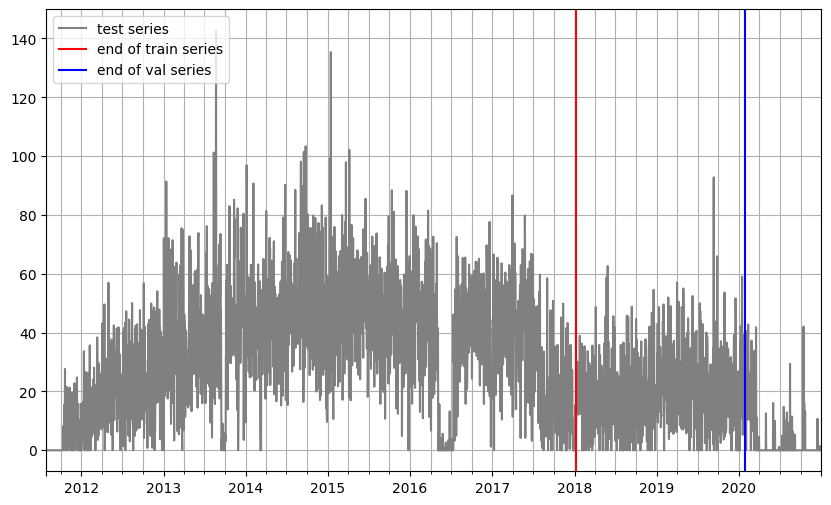

<Figure size 640x480 with 0 Axes>

In [96]:
visualize_train_val_test_data(train_ds, val_ds, test_ds)

#### Train and prediction

In [97]:
from gluonts.model.predictor import Predictor

##### Simple feed forward estimator

In [141]:
# defining a callback, which will log the training loss for each epoch
history = TrainingHistory()

In [142]:
simple_feed_forward_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[50], ## default: 50
    prediction_length=prediction_length,
    batch_normalization = False, ## default: false
    mean_scaling = True, ## default: true
    context_length=100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### MQCNN estimator

In [143]:
from gluonts.mx import MQCNNEstimator, Trainer

In [144]:
mqcnn_estimator = MQCNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    use_feat_dynamic_real=True,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### MQRNN estimator

In [145]:
from gluonts.mx import MQRNNEstimator, Trainer

In [213]:
mqrnn_estimator = MQRNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=2, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### DeepAR estimator

In [147]:
from gluonts.mx import DeepAREstimator, Trainer

In [194]:
deepAR_estimator = DeepAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    num_layers = 2, ## number of LSTM layers
    use_feat_dynamic_real=True,
    dropout_rate = 0.1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### DeepVAR estimator

In [149]:
from gluonts.mx import DeepVAREstimator, Trainer

In [150]:
deepVAR_estimator = DeepVAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    num_layers = 2, ## number of LSTM layers
    dropout_rate=0.1,
    use_feat_dynamic_real=True,
    target_dim= 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### LSTNet

In [151]:
from gluonts.mx import LSTNetEstimator, Trainer

In [206]:
for entry in train_ds:
    print(entry['target'].shape)
    break

(2357,)


In [207]:
lstnet_estimator = LSTNetEstimator(
    num_series = 46,
    prediction_length = prediction_length,
    ar_window = 10,
    channels = 1,
    context_length = 30,
    kernel_size = 2,
    skip_size = 1,
    dropout_rate=0.1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Temporal fusion transformer

In [153]:
from gluonts.mx import TemporalFusionTransformerEstimator, Trainer

In [180]:
tft_estimator = TemporalFusionTransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    hidden_dim = 20,
    num_heads = 8,
    dropout_rate=0.1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Transformer estimator

In [155]:
from gluonts.mx import TransformerEstimator, Trainer

In [181]:
transformer_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    context_length = 100,
    num_heads = 8,
    dropout_rate=0.1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Deepfactor estimator

In [157]:
from gluonts.mx import DeepFactorEstimator, Trainer

In [158]:
deepFactor_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### GP estimator

In [159]:
from gluonts.mx import GaussianProcessEstimator, Trainer

In [160]:
gp_estimator = GaussianProcessEstimator(
    freq = freq,
    prediction_length = prediction_length,
    cardinality = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Naive predictor

In [161]:
from gluonts.ext.naive_2 import Naive2Predictor

In [162]:
naive_predictor = Naive2Predictor(
    prediction_length = prediction_length,
    season_length = 100
)

##### Train and predict

In [163]:
def train_and_predict(train_dataset, val_dataset, test_dataset, estimator, negative_control):
    predictor = estimator.train(training_data = train_dataset, validation_data = val_dataset)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset = test_dataset, predictor = predictor
    )
    
    return predictor, list(forecast_it), list(ts_it)


In [164]:
def get_model_name(estimator):
    s = str(estimator)

    start_marker = ".model."
    end_marker = "._estimator"

    start_index = s.find(start_marker)
    if(start_index == -1):
        raise ValueError("Couldn't find start index!")

    end_index = s.find(end_marker, start_index)
    if(end_index == -1):
        return ValueError("Couldn't find end index!")
    
    start_index += len(start_marker)
    return s[start_index: end_index]

In [165]:
def replace_negatives_with_zero(data):
    return [max(0, x) for x in data]

In [166]:
def multiple_models(train_ds, val_ds, test_ds, estimators, samples):
    predictors_all = []
    agg_metrics_all = []
    item_metrics_all = []
    forecast_it_all = []
    ts_it_all = []
    for estimator in estimators:
        
        ## model training
        predictor, forecast_it, ts_it = train_and_predict(train_ds, val_ds, test_ds, estimator, negative_control = True)

        ## loss curve
        loss_data_framework = get_loss_curve(history)
        export_loss_curve(loss_data_framework, estimator)
        plot_loss_curve(loss_data_framework, estimator)

        ## evluation metrics
        print_forecast_basic_info(forecast_it, ts_it)
        export_original_time_series_no_missing_values(ts_it)
        export_predicted_values(ts_it, forecast_it, estimator)
        plot_orginal_prediction(forecast_it, ts_it, estimator, samples)
        agg_metrics, item_metrics = get_evaluation_metrics(forecast_it, ts_it)
        export_eval_metrics(agg_metrics, item_metrics, estimator)

        predictors_all.append(predictor)
        agg_metrics_all.append(agg_metrics)
        item_metrics_all.append(item_metrics)
        forecast_it_all.append(forecast_it)
        ts_it_all.append(ts_it)

        return predictors_all, agg_metrics_all, item_metrics_all, forecast_it_all, ts_it_all
    

In [167]:
def get_loss_curve(history):
    loss_data_framework = pd.DataFrame({
        "training_loss": history.loss_history,
        "val_loss": history.validation_loss_history
    })
    loss_data_framework.head()
    return loss_data_framework

In [168]:
def export_loss_curve(loss_data_framework, estimator):
    loss_curve_name = "loss_curve_model_{}.csv".format(get_model_name(estimator))
    loss_data_framework.to_csv(loss_curve_name)

In [169]:
def plot_loss_curve(loss_data_framework, estimator):
    # Clear the current figure
    plt.clf()

    loss_data_framework["epochs"] = range(1, len(loss_data_framework) + 1)

    plt.plot(loss_data_framework["epochs"], loss_data_framework["training_loss"], 'o-', label='Training Loss', color='blue', linestyle='--')
    plt.plot(loss_data_framework["epochs"], loss_data_framework["val_loss"], 's-', label='Validation Loss', color='red', linestyle='-.')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.savefig(f'{get_model_name(estimator)}_train_val_loss.jpg')

In [170]:
def print_forecast_basic_info(forecast_it, ts_it):
    forecast_entry = forecast_it[0]
    ts_entry = ts_it[0]

    print(f"Number of sample paths: {forecast_entry.num_samples}")
    print(f"Dimension of samples: {forecast_entry.samples.shape}")
    print(f"Start date of the forecast window: {forecast_entry.start_date}")
    print(f"Frequency of the time series: {forecast_entry.freq}")

In [171]:
def export_original_time_series_no_missing_values(ts_it):

    ts_entry = ts_it[0]
    
    time_series_original = pd.DataFrame(ts_entry)
    time_series_original.columns = ['true_value']
    time_series_original.to_csv("time_series_original_no_missing_values.csv")

In [172]:
def export_predicted_values(ts_it, forecast_it, estimator):
    forecast_entry = forecast_it[0]
    ts_entry = ts_it[0]
    
    predicted_values = "predicted_values_model_{}.csv".format(get_model_name(estimator))
    predicted_values_100_series = pd.DataFrame(forecast_entry.samples.T)
    predicted_values_100_series.to_csv(predicted_values)

In [173]:
def plot_orginal_prediction(forecast_it, ts_it, estimator, samples):
    # Clear the current figure
    plt.figure(figsize=[10, 6])
    
    for i in samples:
        plt.clf()
        forecast_entry = forecast_it[i]
        ts_entry = ts_it[i]

        plt.plot(ts_entry[-800:].to_timestamp())
        forecast_entry.plot(show_label=True)
        plt.legend()
        plt.savefig("testing_{}{}.png".format(get_model_name(estimator), i))

In [174]:
def get_evaluation_metrics(forecast_it, ts_it):

    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it)

    return agg_metrics, item_metrics

In [175]:
def export_eval_metrics(agg_metrics, item_metrics, estimator):
    ## agg_metrics
    print("Evaluation metrics: {}".format(get_model_name(estimator)))
    agg_metrics_data_frame = pd.DataFrame([agg_metrics])

    agg_metrics_csv_name = "agg_metrics_{}.csv".format(get_model_name(estimator))

    item_metrics_csv_name = "item_metrics_{}.csv".format(get_model_name(estimator))

    agg_metrics_data_frame.to_csv(agg_metrics_csv_name)
    item_metrics.to_csv(item_metrics_csv_name)

In [176]:
def map_station_name_index(station_samples):
    station_name_index = station_name_map[station_name_map["Station Name"].isin(station_samples)]
    samples_index = station_name_index['item_id'].tolist()
    return samples_index

In [214]:
station_name_map

,Station Name,item_id
0,BRYANT 1,0
1,BRYANT 2,1
2,BRYANT 3,2
3,BRYANT 4,3
4,BRYANT 5,4
5,BRYANT 6,5
6,CAMBRIDGE 1,6
7,CAMBRIDGE 2,7
8,CAMBRIDGE 3,8
9,CAMBRIDGE 4,9


/usr/local/lib/python3.10/site-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'enc_inputlayer0_dense0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.10/site-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'enc_inputlayer0_dense0_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.10/site-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'enc_layernormalization0_layernorm0_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.10/site-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'enc_layernormalization0_layernorm0_beta' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.init

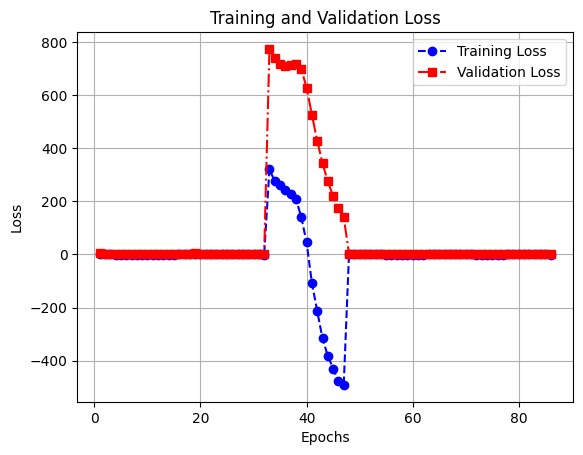

Number of sample paths: 100
Dimension of samples: (100, 336)
Start date of the forecast window: 2020-01-31
Frequency of the time series: <Day>


Running evaluation: 46it [00:00, 90.64it/s]
/usr/local/lib/python3.10/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.10/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error
/usr/local/lib/python3.10/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.10/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error


Evaluation metrics: transformer


<Figure size 640x480 with 0 Axes>

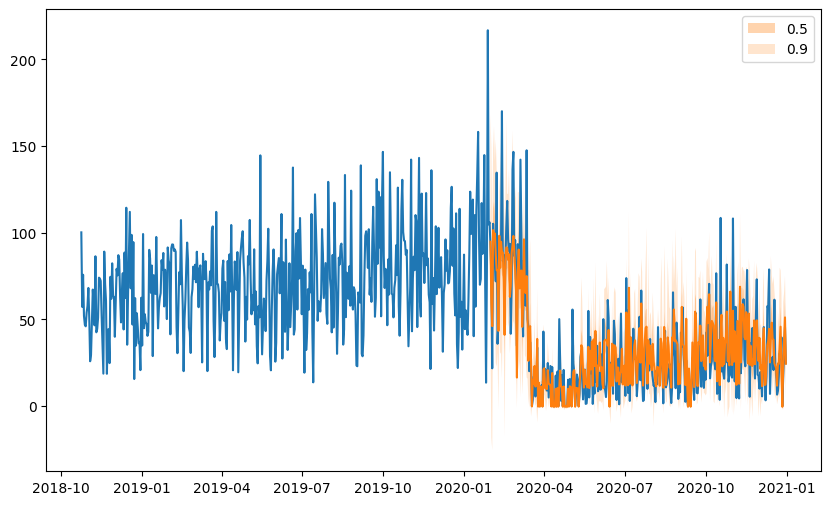

In [216]:
## Available estmators: 
## transformer_estimator: transformer
## tft_estimator: temporal fusion transformer
## lstnet_estimator: LSTnet
## deepVAR_estimator: DeepVAR
## deepAR_estimator: DeepAR
## simple_feed_forward_estimator: MLP
## deepFactor_estimator: deep factor
## gp_estimator: gaussian process
## mqcnn_estimator: MQ CNN
## rnn_estimator: RNN

estimators = [deepFactor_estimator]
model_metrics = {}

## name of sample stations you'd like to plot
station_samples = ["WEBSTER 1", "MPL 5", "RINCONADA LIB 1", "BRYANT 4", "SHERMAN 5", "CAMBRIDGE 1", "HAMILTON 1", "HIGH 2"]
samples_index = map_station_name_index(station_samples)

predictor, agg_metrics, item_metrics, forecast_it, ts_it = multiple_models(train_ds, val_ds, test_ds, estimators, samples_index)

#### Model selection

In [219]:
def calculate_combined_scores(weight_dict, file_dict, model_list):
    # Read the metrics from CSV files
    metrics = {}
    for model, filepath in file_dict.items():
        metrics[model] = pd.read_csv(filepath, index_col=0)
    
    # Combine all metrics into a single DataFrame
    combined_agg_metrics = pd.concat([metrics[model] for model in model_list], axis=0)
    combined_agg_metrics.index = model_list
    
    # Dictionary to store combined scores for each model
    agg_metrics_multiple_models = {}
    results = []
    
    # Calculate combined score for each model
    for model in combined_agg_metrics.index:
        combined_score = sum(weight_dict[metric] * combined_agg_metrics.loc[model][metric] for metric in weight_dict)
        agg_metrics_multiple_models[model] = combined_score
        
        # Store the result as a dictionary
        result = {
            'Model': model,
            'Combined Score': combined_score
        }
        for metric in weight_dict:
            result[metric] = combined_agg_metrics.loc[model][metric]
        
        results.append(result)
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort the results DataFrame by 'Combined Score' in ascending order (best to worst)
    results_df = results_df.sort_values(by='Combined Score', ascending=True)
    
    # Determine the best model based on the lowest combined score
    best_model = results_df.iloc[0]['Model']
    
    print(f"Best Model: {best_model}")
    
    return results_df, best_model


In [222]:
weights = {
    'sMAPE': 0.3,
    'NRMSE': 0.3,
    'QuantileLoss[0.9]': 0.1,
    'QuantileLoss[0.5]': 0.2,
    'QuantileLoss[0.1]': 0.1
}

file_paths = {
    'simple_feed_forward': "agg_metrics_simple_feedforward.csv",
    'deepAR': "agg_metrics_deepar.csv",
    'gp': "agg_metrics_gp_forecaster.csv",
    'transformer': "agg_metrics_transformer.csv",
    'deepFactor': "agg_metrics_deepFactor.csv"
}

models = ['simple_feed_forward', 'deepAR', 'gp', 'transformer', 'deepFactor']

# Call the function
results_df, best_model = calculate_combined_scores(weights, file_paths, models)

# Display the results DataFrame
print(results_df)

Best Model: deepFactor
                 Model  Combined Score     sMAPE     NRMSE  QuantileLoss[0.9]  \
4           deepFactor    20250.805301  1.423067  0.978881       46910.313340   
3          transformer    20827.494296  1.430228  1.007621       50192.499581   
1               deepAR    23900.003217  1.445580  1.058798       67397.304773   
2                   gp    92676.411435  1.539081  2.753171       96029.786613   
0  simple_feed_forward   107413.562789  1.570587  3.556600      159992.543505   

   QuantileLoss[0.5]  QuantileLoss[0.1]  
4       65654.817235       24280.899354  
3       67430.973447       23213.182939  
1       73387.019873       24821.174516  
2      286250.950216      258219.550544  
0      343805.857099      226515.988626  


#### Fine tuning

In [223]:
def dataentry_to_dataframe(entry):
    df = pd.DataFrame(
        entry["target"],
        columns=[entry.get("item_id")],
        index=pd.period_range(
            start=entry["start"], periods=len(entry["target"]), freq=entry["start"].freq
        ),
    )

    return df

In [246]:
class modelTuningObjective:
    def __init__(
        self, dataset, prediction_length, freq, metric_type="mean_wQuantileLoss"
    ):
        self.dataset = dataset
        self.prediction_length = prediction_length
        self.freq = freq
        self.metric_type = metric_type

        self.train, test_template = split(dataset, offset=-self.prediction_length)
        validation = test_template.generate_instances(
            prediction_length=prediction_length
        )
        self.validation_input = [entry[0] for entry in validation]
        self.validation_label = [
            dataentry_to_dataframe(entry[1]) for entry in validation
        ]

    def get_params(self, trial) -> dict:
        return {
            "num_layers": trial.suggest_int("num_layers", 1, 5),
            "hidden_size": trial.suggest_int("hidden_size", 10, 50),
            "num_hidden_dimensions": trial.suggest_int("num_hidden_dimensions", 20, 80),
            "context_length": trial.suggest_int("context_length", 20, 140),
            "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.1),
            "num_batches_per_epoch": trial.suggest_int("num_batches_per_epoch", 20, 120),
            "dropout_rate": trial.suggest_uniform("dropout_rate", 0.0, 0.3),
            "num_layers": trial.suggest_int("num_layers", 2, 8),
            "num_heads": trial.suggest_int("num_heads", 2, 16),
            "num_hidden_global": trial.suggest_int("num_hidden_global", 40, 60),
            "num_hidden_local": trial.suggest_int("num_hidden_local", 4, 6),
            "num_factors": trial.suggest_int("num_factors", 9,12)
        }

    def __call__(self, trial):
        params = self.get_params(trial)
        estimator = DeepAREstimator(
                num_layers=params["num_layers"],
                prediction_length=self.prediction_length,
                freq=self.freq,
                trainer=Trainer(
                    ctx="cpu", 
                    epochs=1, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                ),
            )

        # estimator = estimator = TransformerEstimator(
        #         freq = self.freq,
        #         prediction_length = prediction_length,
        #         use_feat_dynamic_real=True,
        #         # num_hidden_global = params["num_hidden_global"],
        #         # num_factors = params["num_factors"],
        #         # num_hidden_local = params["num_hidden_local"],
        #         trainer=Trainer(
        #             ctx="cpu", 
        #             epochs=5, 
        #             learning_rate=1e-3, 
        #             num_batches_per_epoch=params["num_batches_per_epoch"]
        #         ),
        #     )

        if(best_model == "simple_feed_forward_estimator"):
            estimator = SimpleFeedForwardEstimator(
                num_hidden_dimensions=[params["num_hidden_dimensions"]], ## default: 50
                prediction_length=self.prediction_length,
                batch_normalization = False, ## default: false
                mean_scaling = True, ## default: true
                context_length=100,
                trainer=Trainer(
                    ctx="cpu", 
                    epochs=1, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                ),
            )

        elif(best_model == "gp_estimator"):
            estimator = GaussianProcessEstimator(
                freq = self.freq,
                prediction_length = self.prediction_length,
                cardinality = 1,
                trainer=Trainer(
                    ctx="cpu", 
                    epochs=1, 
                    learning_rate=params["learning_rate"], 
                    num_batches_per_epoch=params["num_batches_per_epoch"]
                ),
            )
            
        elif(best_model == "transformer_estimator"):
            estimator = TransformerEstimator(
                freq = self.freq,
                prediction_length = self.prediction_length,
                use_feat_dynamic_real=True,
                context_length = 100,
                dropout_rate=params["learning_rate"],
                num_heads = params["num_heads"],
                trainer=Trainer(
                    ctx="cpu", 
                    epochs=1, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                ),
            )

        elif(best_model == "deepFactor_estimator"):
            estimator = TransformerEstimator(
                freq = self.freq,
                prediction_length = prediction_length,
                use_feat_dynamic_real=True,
                num_hidden_global = params["num_hidden_global"],
                num_factors = params["num_factors"],
                num_hidden_local = params["num_hidden_local"],
                trainer=Trainer(
                    ctx="cpu", 
                    epochs=20, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                ),
            )

        # elif(best_model == "tft_estimator"):
        #     estimator = TemporalFusionTransformerEstimator(
        #         freq = self.freq,
        #         prediction_length = prediction_length,
        #         hidden_dim = 20,
        #         num_heads = params["num_heads"],
        #         dropout_rate=0.1,
        #         trainer=Trainer(
        #             ctx="cpu", 
        #             epochs=1, 
        #             learning_rate=params["learning_rate"], 
        #             num_batches_per_epoch=params["num_batches_per_epoch"]
        #         ),
        #     )

        # elif(best_model == "deepVAR_estimator"):
        #     estimator = DeepVAREstimator(
        #         freq = self.freq,
        #         prediction_length = prediction_length,
        #         num_layers = params["num_layers"], ## number of LSTM layers
        #         dropout_rate=0.1,
        #         use_feat_dynamic_real=True,
        #         target_dim= 1,
        #         trainer=Trainer(
        #             ctx="cpu", 
        #             epochs=1, 
        #             learning_rate=params["learning_rate"], 
        #             num_batches_per_epoch=params["num_batches_per_epoch"]
        #         ),
        #     )

        predictor = estimator.train(self.train, cache_data=True)
        forecast_it = predictor.predict(self.validation_input)

        forecasts = list(forecast_it)

        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
        agg_metrics, item_metrics = evaluator(
            self.validation_label, forecasts, num_series=len(self.dataset)
        )
        return agg_metrics[self.metric_type]

In [247]:
## transformer_estimator: transformer
## tft_estimator: temporal fusion transformer
## lstnet_estimator: LSTnet
## deepVAR_estimator: DeepVAR
## deepAR_estimator: DeepAR
## simple_feed_forward_estimator: MLP
## deepFactor_estimator: deep factor
## gp_estimator: gaussian process
## mqcnn_estimator: MQ CNN
## rnn_estimator: RNN

In [248]:
import time

best_model == "deepFactor_estimator"

start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(
    modelTuningObjective(
        val_ds, validation_length, freq
    ),
    n_trials=2,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
print(time.time() - start_time)

[I 2024-08-28 16:57:10,192] A new study created in memory with name: no-name-58b3d3e4-994c-4548-9591-0cea76b5ece1
/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_42428/3022669974.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.1),
/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_42428/3022669974.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "dropout_rate": trial.suggest_uniform("dropout_rate", 0.0, 0.3),
/usr/local/lib/python3.10/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_layers"! This might be a configuration mistake. Optuna allows 

100%|██████████| 104/104 [03:14<00:00,  1.87s/it, epoch=5/5, avg_epoch_loss=0.872]
[W 2024-08-28 17:14:29,235] Trial 0 failed with parameters: {'num_layers': 5, 'hidden_size': 10, 'num_hidden_dimensions': 39, 'context_length': 84, 'learning_rate': 0.026384906010798178, 'num_batches_per_epoch': 104, 'dropout_rate': 0.22657118390745656, 'num_heads': 3, 'num_hidden_global': 56, 'num_hidden_local': 5, 'num_factors': 12} because of the following error: ValueError('all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2771 and the array at index 2 has size 3108').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_42428/3022669974.py", line 158, in __call__
    forecasts = list(forecast_it)
  File "/usr/local/lib/python3.10/site-packa

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2771 and the array at index 2 has size 3108

### Re-training the model

In [228]:
final_estimator = DeepAREstimator(
    freq = freq,
    num_layers=trial.params["num_layers"],
    prediction_length = validation_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=5, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

if(best_model == "simple_feed_forward_estimator"):
    final_estimator  = SimpleFeedForwardEstimator(
        num_hidden_dimensions=[params["num_hidden_dimensions"]], ## default: 50
        prediction_length=self.prediction_length,
        batch_normalization = False, ## default: false
        mean_scaling = True, ## default: true
        context_length=100,
        freq=self.freq,
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=1e-3, 
            num_batches_per_epoch=100
        ),
    )

elif(best_model == "gp_estimator"):
    final_estimator  = GaussianProcessEstimator(
        freq = self.freq,
        prediction_length = self.prediction_length,
        cardinality = 1,
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=params["learning_rate"], 
            num_batches_per_epoch=params["num_batches_per_epoch"]
        ),
    )
            
elif(best_model == "transformer_estimator"):
    final_estimator  = TransformerEstimator(
        freq = self.freq,
        prediction_length = self.prediction_length,
        use_feat_dynamic_real=True,
        context_length = 100,
        dropout_rate=params["learning_rate"],
        num_heads = params["num_heads"],
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=1e-3, 
            num_batches_per_epoch=100
        ),
    )

elif(best_model == "deepFactor_estimator"):
    final_estimator  = TransformerEstimator(
        freq = self.freq,
        prediction_length = prediction_length,
        use_feat_dynamic_real=True,
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=1e-3, 
            num_batches_per_epoch=100
        ),
    )

elif(best_model == "tft_estimator"):
    final_estimator  = TemporalFusionTransformerEstimator(
        freq = self.freq,
        prediction_length = prediction_length,
        hidden_dim = 20,
        num_heads = params["num_heads"],
        dropout_rate=0.1,
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=params["learning_rate"], 
            num_batches_per_epoch=params["num_batches_per_epoch"]
        ),
    )

elif(best_model == "deepVAR_estimator"):
    final_estimator  = DeepVAREstimator(
        freq = self.freq,
        prediction_length = prediction_length,
        num_layers = params["num_layers"], ## number of LSTM layers
        dropout_rate=0.1,
        use_feat_dynamic_real=True,
        target_dim= 1,
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=params["learning_rate"], 
            num_batches_per_epoch=params["num_batches_per_epoch"]
        ),
    )

NameError: name 'trial' is not defined

In [346]:
final_predictor = final_estimator.train(training_data = train_ds, validation_data = val_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:24<00:00,  1.44s/it, epoch=1/5, avg_epoch_loss=1.28]
2it [00:04,  2.42s/it, epoch=1/5, validation_avg_epoch_loss=3.66]
100%|██████████| 100/100 [02:15<00:00,  1.35s/it, epoch=2/5, avg_epoch_loss=0.594]
2it [00:00,  3.91it/s, epoch=2/5, validation_avg_epoch_loss=3.67]
100%|██████████| 100/100 [02:21<00:00,  1.41s/it, epoch=3/5, avg_epoch_loss=0.281]
2it [00:00,  3.25it/s, epoch=3/5, validation_avg_epoch_loss=3.49]
100%|██████████| 100/100 [02:18<00:00,  1.38s/it, epoch=4/5, avg_epoch_loss=0.441]
2it [00:00,  3.29it/s, epoch=4/5, validation_avg_epoch_loss=3.5]
100%|██████████| 100/100 [02:18<00:00,  1.39s/it, epoch=5/5, avg_epoch_loss=0.0675]
2it [00:00,  3.77it/s, epoch=5/5, validation_avg_epoch_loss=3.4]


In [347]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=final_predictor,
)

In [348]:
forecasts = list(forecast_it)
tss = list(ts_it)

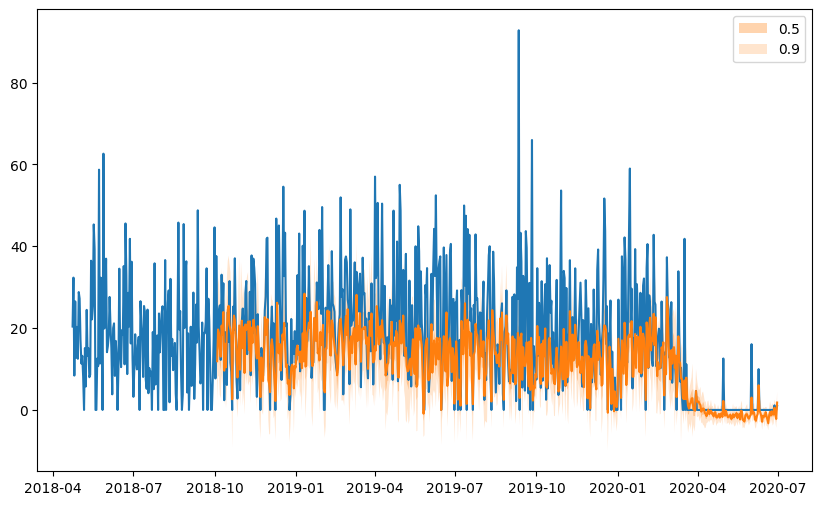

In [350]:
plt.figure(figsize = [10, 6])
plt.plot(tss[0][-800:].to_timestamp())
forecasts[0].plot(show_label=True)
plt.legend()

In [351]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 33it [00:00, 64.86it/s]


In [352]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 337.32617464350915,
    "abs_error": 258513.86889648438,
    "abs_target_sum": 628497.1832275391,
    "abs_target_mean": 29.945549038857393,
    "seasonal_error": 7.338608075601793,
    "MASE": 4.031481251252466,
    "MAPE": 0.7406278837668889,
    "sMAPE": 0.8012976023908659,
    "MSIS": 48.971383673901684,
    "QuantileLoss[0.1]": 85093.24119773698,
    "Coverage[0.1]": 0.09538784067085952,
    "QuantileLoss[0.5]": 258513.86919797107,
    "Coverage[0.5]": 0.44863731656184486,
    "QuantileLoss[0.9]": 206261.12291025434,
    "Coverage[0.9]": 0.7140270630836669,
    "RMSE": 18.366441534589903,
    "NRMSE": 0.6133279276582165,
    "ND": 0.41132064835824866,
    "wQuantileLoss[0.1]": 0.13539160312661275,
    "wQuantileLoss[0.5]": 0.4113206488379432,
    "wQuantileLoss[0.9]": 0.32818145954296224,
    "mean_absolute_QuantileLoss": 183289.41110198747,
    "mean_wQuantileLoss": 0.2916312371691727,
    "MAE_Coverage": 0.338009021027889,
    "OWA": NaN
}


In [353]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2018-10-04,131.027921,4804.730469,11239.745117,17.672555,14.177859,0.532845,0.400037,0.775413,0.427477,6.207161,1577.067090,0.012579,4804.730328,0.248428,4213.884938,0.591195
1,None,2018-10-04,171.571148,5366.705078,12366.260742,19.443806,14.518088,0.581221,0.864169,0.747048,0.433980,7.023239,1725.099325,0.036164,5366.705323,0.308176,4705.345126,0.630503
2,None,2018-10-04,175.486316,5490.879883,10674.236328,16.783390,4.939351,1.747893,1.963200,0.883876,0.514405,22.767583,1679.078052,0.056604,5490.879727,0.317610,5167.631041,0.589623
3,None,2018-10-04,342.590654,8403.558594,19039.054688,29.935621,3.323311,3.975897,0.464102,0.716048,0.441385,33.853508,2679.603926,0.031447,8403.558814,0.314465,6286.646862,0.647799
4,None,2018-10-04,273.799946,7935.820312,25315.136719,39.803674,3.578113,3.487230,0.420809,0.558546,0.313481,21.518697,2837.845733,0.081761,7935.820287,0.454403,4194.211054,0.812893


### Save existing model

In [ ]:
# save the trained model in tmp/
from pathlib import Path
final_predictor.serialize(Path("/tmp/"))

# loads it back
from gluonts.model.predictor import Predictor
final_predictor_deserialized = Predictor.deserialize(Path("/tmp/"))